# Cyberbullying Classification by Type
The objective of this work is to create a multi-label classification model to classify the text according to a set of cyberbullying types - Sexual_Type1, Sexual_Type2, Physical_Appearance, Race, Intellectual, Religious, General Hate, and Neutral.

## Import Python Packages

In [1]:
import pandas as pd
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
stopwords_default=stopwords.words('english')

from appos.appos import appos_dict
from slangs.slangs import slangs_dict
from emoticons.emoticons import emoticons

from langdetect import detect
from translate import Translator
from spellchecker import SpellChecker

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Albert\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Extraction
The process to extract data from a given .csv files.

In [2]:
# Setting the folder path to the location of original dataset
folder_path = r"./Dataset/"

# Create an empty list for storing the created dataframe from original dataset
filtered_dfs = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    # Read only files with name ends with .xlsx
    if filename.endswith('.xlsx'):
        excel_file = os.path.join(folder_path, filename)
        xlsx = pd.ExcelFile(excel_file)
        sheet_names = xlsx.sheet_names # Read the sheet names contain inside the excel file
        dataframe = {}
        defined_column_name = ["Comment_Number",
                               "Commenter_Username",
                               "Comment",
                               "Comment_Post_Time",
                               "Overall_CB_Status",
                               "CB_Type",
                               "Sexual_Type1", "Unnamed_1", "Unnamed_2",
                               "Sexual_Type2", "Unnamed_3", "Unnamed_4",
                               "Physical_Appearance", "Unnamed_5", "Unnamed_6",
                               "Race", "Unnamed_7", "Unnamed_8",
                               "Intellectual", "Unnamed_9", "Unnamed_10",
                               "Religious", "Unnamed_11", "Unnamed_12",
                               "General_Hate", "Unnamed_13", "Unnamed_14",
                               "Purpose_of_CB",
                               "Insult", "Unnamed_15", "Unnamed_16",
                               "Defensive", "Unnamed_17", "Unnamed_18",
                               "Directionality", 
                               "Directed_Username", "Unnamed_19", "Unnamed_20",
                               "Other_Aspects",
                               "Depression", "Unnamed_21", "Unnamed_22",
                               "Suicides", "Unnamed_23", "Unnamed_24",
                               "Stress", "Unnamed_25", "Unnamed_26",
                               "Discrimination", "Unnamed_27", "Unnamed_28"]
        
        for sheet_name in sheet_names:
            # Retrive the dataframe for that specific sheet name
            dataframe[sheet_name] = pd.read_excel(excel_file, sheet_name)
            
            # Redefine the columns' name based on the defined_column_name
            try:
                dataframe[sheet_name].columns = defined_column_name
            except:
                print(f'{filename} : {sheet_name}.')
                
        
        for item in dataframe.values():
            # Drop the first two rows of the dataframe due to formatting issue
            item = item.drop(item.index[:2])
            
            # Drop unnecessary attributes/columns from the dataframe
            columns_to_drop = [col for col in item.columns if any(substring in col for substring in ["Comment_Number",
                                                                                                     "Unnamed",
                                                                                                     "Commenter_Username",
                                                                                                     "Comment_Post_Time",
                                                                                                     "CB_Type", 
                                                                                                     "Purpose_of_CB",
                                                                                                     "Insult",
                                                                                                     "Religious",
                                                                                                     "Defensive",
                                                                                                     "Other_Aspects",
                                                                                                     'Suicides',
                                                                                                     "Stress",
                                                                                                     "Depression",
                                                                                                     "Discrimination",
                                                                                                     "Directionality", 
                                                                                                    "Directed_Username"])]

            filter_df = item.drop(columns=columns_to_drop)
            # Store the dataframe to filtered_dfs
            filtered_dfs.append(filter_df)

## Data Preprocessing
In this stage, we are checking for the followings:
* Remove any duplicates items in the 'Comment' columns
* Missing values in the attributes, any missing values will be replaced by 0
* Check for dataframe data types and perform data type conversion
* Check for error data
* Text formatting

### Removal of Duplicates Data for 'Comments' attribute

In [3]:
# Concatenate all the filtered dataframes into one
df = pd.concat(filtered_dfs, ignore_index=True)

# Removal of duplicates items in the 'Comment' column
df = df.drop_duplicates(subset='Comment')
df = df.dropna(subset='Comment')

### Replacing NA values with 0

An assumption is made that the all the cyberbullying texts in the provided original datasets have been correctly labelled as 1. Therefore, the remaining data with NA values will be labelled as 0 which is not a cyberbullying text.

In [4]:
# Check NA value exists in the concatenated dataframe
check_na = df.isna()
max_retries = 2
retry_count = 0

# Replace NA value to 0 if presents in the dataframe
while (check_na == True).any().any() and retry_count < max_retries:
    print("NA values found in the DataFrame. Replacing NA values with 0......")            
    df = df.fillna(0)
    check_na = df.isna()
    retry_count += 1
          
if (check_na == True).any().any():
    print("Maximum retries reached. Some NA values could not be replaced.")
else:
    print("No NA values founds in the datasets.")

NA values found in the DataFrame. Replacing NA values with 0......
No NA values founds in the datasets.


### Check for Attributes' Data Type
According to the attributes' characteristics, all attributes should be in int (1 : True and 0 : False) with the exceptions for 'Comment' which should be in string/object type. 

In [5]:
# Check for dataframe's data types
df.dtypes

Comment                object
Overall_CB_Status       int64
Sexual_Type1           object
Sexual_Type2            int64
Physical_Appearance     int64
Race                   object
Intellectual            int64
General_Hate           object
dtype: object

In [6]:
selected_column = ['Sexual_Type1', 'Race', 'General_Hate']

# Performing data type conversion according to their attributes
for column_name in selected_column:
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce').fillna(0)
    df[column_name] = df[column_name].astype('int64')

print(df.dtypes)

Comment                object
Overall_CB_Status       int64
Sexual_Type1            int64
Sexual_Type2            int64
Physical_Appearance     int64
Race                    int64
Intellectual            int64
General_Hate            int64
dtype: object


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7942 entries, 0 to 8499
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Comment              7942 non-null   object
 1   Overall_CB_Status    7942 non-null   int64 
 2   Sexual_Type1         7942 non-null   int64 
 3   Sexual_Type2         7942 non-null   int64 
 4   Physical_Appearance  7942 non-null   int64 
 5   Race                 7942 non-null   int64 
 6   Intellectual         7942 non-null   int64 
 7   General_Hate         7942 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 558.4+ KB


### Check for Error Data
Since all attributes with the exception of 'Comments' are in int (1 : True, 0 : False), and thus the min and max value within the attribute should be either 0 or 1 only.

Any error data will be removed from the dataframe.

In [8]:
df.describe()

Overall_CB_Status  Sexual_Type1  Sexual_Type2  Physical_Appearance  \
count        7942.000000   7942.000000   7942.000000          7942.000000   
mean            0.134097      0.028834      0.013473             0.019391   
std             0.341885      0.167350      0.115295             0.137902   
min             0.000000      0.000000      0.000000             0.000000   
25%             0.000000      0.000000      0.000000             0.000000   
50%             0.000000      0.000000      0.000000             0.000000   
75%             0.000000      0.000000      0.000000             0.000000   
max             3.000000      1.000000      1.000000             1.000000   

              Race  Intellectual  General_Hate  
count  7942.000000   7942.000000   7942.000000  
mean      0.013725      0.019265      0.068371  
std       0.116352      0.137462      0.252397  
min       0.000000      0.000000      0.000000  
25%       0.000000      0.000000      0.000000  
50%       0.000000      0.000000      0.000000  
75%       0.000000      0.000000      0.000000  
max       1.000000      1.000000      1.000000

For 'Overall_CB_Status' attribute, it contains value larger than 1. Therefore, the respective rows with value greater than 1 should be removed from the dataset.

In [9]:
# Print rows where one of the attributes is equal to 3
df = df[(df['Overall_CB_Status'] <= 1)]
df.describe()

Overall_CB_Status  Sexual_Type1  Sexual_Type2  Physical_Appearance  \
count        7941.000000   7941.000000   7941.000000          7941.000000   
mean            0.133736      0.028838      0.013474             0.019393   
std             0.340390      0.167361      0.115302             0.137911   
min             0.000000      0.000000      0.000000             0.000000   
25%             0.000000      0.000000      0.000000             0.000000   
50%             0.000000      0.000000      0.000000             0.000000   
75%             0.000000      0.000000      0.000000             0.000000   
max             1.000000      1.000000      1.000000             1.000000   

              Race  Intellectual  General_Hate  
count  7941.000000   7941.000000   7941.000000  
mean      0.013726      0.019267      0.068379  
std       0.116359      0.137471      0.252412  
min       0.000000      0.000000      0.000000  
25%       0.000000      0.000000      0.000000  
50%       0.000000      0.000000      0.000000  
75%       0.000000      0.000000      0.000000  
max       1.000000      1.000000      1.000000

## Text Cleaning

In [10]:
text_formatting = df.copy()

In [48]:
def text_to_lower(text):
    if isinstance (text, str):
        lower_text = str(text.lower())
    else:
        lower_text = str(text)
    return lower_text

def appos_look_up(text):
    words = text.split()
    new_text = []
    for word in words:
        word_s = word.lower()
        if word_s in appos_dict:
            new_text.append(appos_dict[word_s])
        else:
            new_text.append(word)
    apposed = " ".join(new_text)
    return apposed

def remove_words_start_with(text, starts_with_char):
    urls = re.finditer(starts_with_char + r'[A-Za-z0-9\w]*', text)
    for i in urls:
        text = re.sub(i.group().strip(), '', text)
    return text.strip()

def separate_digit_text(text):
    regex_patter = re.compile(r'([\d]+)([a-zA-Z]+)')
    clean_text = regex_patter.sub(r'\1 \2', text)
    return clean_text

def slang_look_up(text):
    words = text.split()
    new_text = []

    for word in words:
        word_s = word.lower()
        if word_s in slangs_dict:
            new_text.append(slangs_dict[word_s])
        else:
            new_text.append(word)
    slanged = " ".join(new_text)
    return slanged

def remove_punctuations(text):
    regex_pattern = re.compile(r'[\,+\:\?\!\"\(\)!\'\.\%\[\]]+')
    clean_text = regex_pattern.sub(r' ', text)
    clean_text = clean_text.replace('-', '')
    return clean_text

def remove_extra_space(text):
    clean_text = ' '.join(text.strip().split())
    return clean_text

def emoticons_look_up(text):
    words = text.split()
    for word in words:
        if word in emoticons:
            text = text.replace(word, emoticons[word])
    return text

def removal_non_letter_digit_whitespaces(text):
    pattern = r'[^a-zA-Z0-9\s]'  # Matches any character that is not a letter, digit, or whitespace
    text = re.sub(pattern, ' ', text)
    text = ' '.join(text.split())
    return text

def remove_single_char_word(text):
    words = text.split()
    filter_words = [word for word in words if len(word) > 1]
    return " ".join(filter_words)

def remove_repeated_characters(text):
    """
    Remove repeated characters (>2) in words to max limit of 2
    Example: I am verrry happpyyy today => I am verry happyy today
    Args:
        text (str): text
    Returns:
        clean_text (str): cleaned text with removed repeated chars
    """
    regex_pattern = re.compile(r'(.)\1+')
    text = regex_pattern.sub(r'\1\1', text)
    return text

def removal_of_digits(text):
    regex_pattern = re.compile(r'[0-9]')
    text = regex_pattern.sub('', text)
    return text

def remove_stop_words(text, stop_words=stopwords_default):
    stop_words = set(stopwords_default)
    split_list = text.split(" ")
    split_list = [word for word in split_list if word not in stop_words]
    return " ".join(split_list)

def check_word_spelling(text):
    # Initialize the spell checker
    spell = SpellChecker()
    # Tokenize the text into words
    words = text.split()
    # Create a dictionary to store misspelled words and their corrected versions
    misspelled_dict = {}

    # Iterate through the words in the text
    for word in words:
        # Check if the word is misspelled
        if word in spell.unknown(words):
            # Get the one `most likely` correction
            corrected_word = spell.correction(word)
            # Store the misspelled word and its correction in the dictionary
            misspelled_dict[word] = corrected_word

    # Replace misspelled words with their corrected versions in the text
    for misspelled, corrected in misspelled_dict.items():
        if corrected is not None:
            text = text.replace(misspelled, corrected)

    return text

def remove_words_ending_with_com(text):
    # Define a regular expression pattern to match words ending with ".com"
    pattern = r'\b\w+\.com\b'
    # Use the re.sub function to replace all matches with an empty string
    text = re.sub(pattern, '', text)
    return text

In [49]:
text_formatting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6774 entries, 0 to 8499
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Comment              6774 non-null   object
 1   Overall_CB_Status    6774 non-null   int64 
 2   Sexual_Type1         6774 non-null   int64 
 3   Sexual_Type2         6774 non-null   int64 
 4   Physical_Appearance  6774 non-null   int64 
 5   Race                 6774 non-null   int64 
 6   Intellectual         6774 non-null   int64 
 7   General_Hate         6774 non-null   int64 
 8   Tokenized            6774 non-null   object
 9   Stemmed_NLTK         6774 non-null   object
 10  Lemmatized_NLTK      6774 non-null   object
dtypes: int64(7), object(4)
memory usage: 635.1+ KB


In [13]:
text_formatting['Comment'] = text_formatting['Comment'].apply(lambda x : text_to_lower(x))
starts_with_char_list = ['@', '#']
for char in starts_with_char_list:
    text_formatting['Comment'] = text_formatting['Comment'].apply(lambda x : remove_words_start_with(x,starts_with_char=char))
text_formatting['Comment'] = text_formatting['Comment'].apply(lambda x : remove_words_ending_with_com(x))
text_formatting['Comment'] = text_formatting['Comment'].apply(lambda x : separate_digit_text(x))
text_formatting['Comment'] = text_formatting['Comment'].apply(lambda x : removal_of_digits(x))
text_formatting['Comment'] = text_formatting['Comment'].apply(lambda x : appos_look_up(x))
text_formatting['Comment'] = text_formatting['Comment'].apply(lambda x : slang_look_up(x))
text_formatting['Comment'] = text_formatting['Comment'].apply(lambda x : emoticons_look_up(x))
text_formatting['Comment'] = text_formatting['Comment'].apply(lambda x : remove_punctuations(x))
text_formatting['Comment'] = text_formatting['Comment'].apply(lambda x : remove_repeated_characters(x))
text_formatting['Comment'] = text_formatting['Comment'].apply(lambda x : remove_single_char_word(x))
text_formatting['Comment'] = text_formatting['Comment'].apply(lambda x : remove_stop_words(x))
text_formatting['Comment'] = text_formatting['Comment'].apply(lambda x : removal_non_letter_digit_whitespaces(x))
text_formatting['Comment'] = text_formatting['Comment'].apply(lambda x : remove_extra_space(x))

In [14]:
text_formatting = text_formatting[text_formatting['Comment'] != '']

In [15]:
text_formatting['Comment'] = text_formatting['Comment'].apply(lambda x : check_word_spelling(x))

In [17]:
text_formatting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6774 entries, 0 to 8499
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Comment              6774 non-null   object
 1   Overall_CB_Status    6774 non-null   int64 
 2   Sexual_Type1         6774 non-null   int64 
 3   Sexual_Type2         6774 non-null   int64 
 4   Physical_Appearance  6774 non-null   int64 
 5   Race                 6774 non-null   int64 
 6   Intellectual         6774 non-null   int64 
 7   General_Hate         6774 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 476.3+ KB


In [19]:
file_path = './preprocess_data_v3.csv'
text_formatting.to_csv(file_path, index=False)

In [23]:
from nltk.stem import WordNetLemmatizer, PorterStemmer

In [24]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')

# Function for tokenization using NLTK
def tokenize_nltk(text):
    return word_tokenize(text)

# Function for lemmatization using NLTK
def lemmatize_nltk(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

# Function for stemming using NLTK
def stem_nltk(tokens):
    stemmer = PorterStemmer()
    return [stemmer.stem(token) for token in tokens]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Albert\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Albert\AppData\Roaming\nltk_data...


In [26]:
# Apply tokenization, lemmatization, and stemming to the 'Comment' column
text_formatting['Tokenized'] = text_formatting['Comment'].apply(tokenize_nltk)
text_formatting['Stemmed_NLTK'] = text_formatting['Tokenized'].apply(stem_nltk)
text_formatting['Lemmatized_NLTK'] = text_formatting['Tokenized'].apply(lemmatize_nltk)

In [28]:
lematizer=WordNetLemmatizer()
def lemmatizer_words(text):
    return " ".join([lematizer.lemmatize(word) for word in text.split()])

text_formatting['Comment'] = text_formatting['Comment'].apply(lambda x : lemmatizer_words(x))

In [29]:
text_formatting

Comment  Overall_CB_Status  \
0                                                 zany                  0   
1                                                larry                  0   
2                                                niall                  0   
3                            get gif cannot have phone                  0   
4     larry zany sexy niall liam something stupid back                  0   
...                                                ...                ...   
8495                                         daisy one                  0   
8496              damn really want one booty argentina                  0   
8497                               want blue whale one                  0   
8498                                            puzzle                  0   
8499       rainbow leopard print one love much restock                  0   

      Sexual_Type1  Sexual_Type2  Physical_Appearance  Race  Intellectual  \
0                0             0                    0     0             0   
1                0             0                    0     0             0   
2                0             0                    0     0             0   
3                0             0                    0     0             0   
4                0             0                    0     0             0   
...            ...           ...                  ...   ...           ...   
8495             0             0                    0     0             0   
8496             0             0                    0     0             0   
8497             0             0                    0     0             0   
8498             0             0                    0     0             0   
8499             0             0                    0     0             0   

      General_Hate                                          Tokenized  \
0                0                                             [zany]   
1                0                                            [larry]   
2                0                                            [niall]   
3                0                  [get, gif, can, not, have, phone]   
4                0  [larry, zany, sexy, niall, liam, something, st...   
...            ...                                                ...   
8495             0                                       [daisy, one]   
8496             0      [damn, really, want, one, booties, argentina]   
8497             0                           [want, blue, whale, one]   
8498             0                                           [puzzle]   
8499             0  [rainbow, leopard, print, one, love, much, res...   

                                           Stemmed_NLTK  \
0                                                [zani]   
1                                               [larri]   
2                                               [niall]   
3                     [get, gif, can, not, have, phone]   
4     [larri, zani, sexi, niall, liam, someth, stupi...   
...                                                 ...   
8495                                       [daisi, one]   
8496        [damn, realli, want, one, booti, argentina]   
8497                           [want, blue, whale, one]   
8498                                            [puzzl]   
8499  [rainbow, leopard, print, one, love, much, res...   

                                        Lemmatized_NLTK  
0                                                [zany]  
1                                               [larry]  
2                                               [niall]  
3                     [get, gif, can, not, have, phone]  
4     [larry, zany, sexy, niall, liam, something, st...  
...                                                 ...  
8495                                       [daisy, one]  
8496        [damn, really, want, one, booty, argentina]  
8497                           [want, blue, whale, one]  
8498                           

In [30]:
text_formatting.Overall_CB_Status.unique()

array([0, 1], dtype=int64)

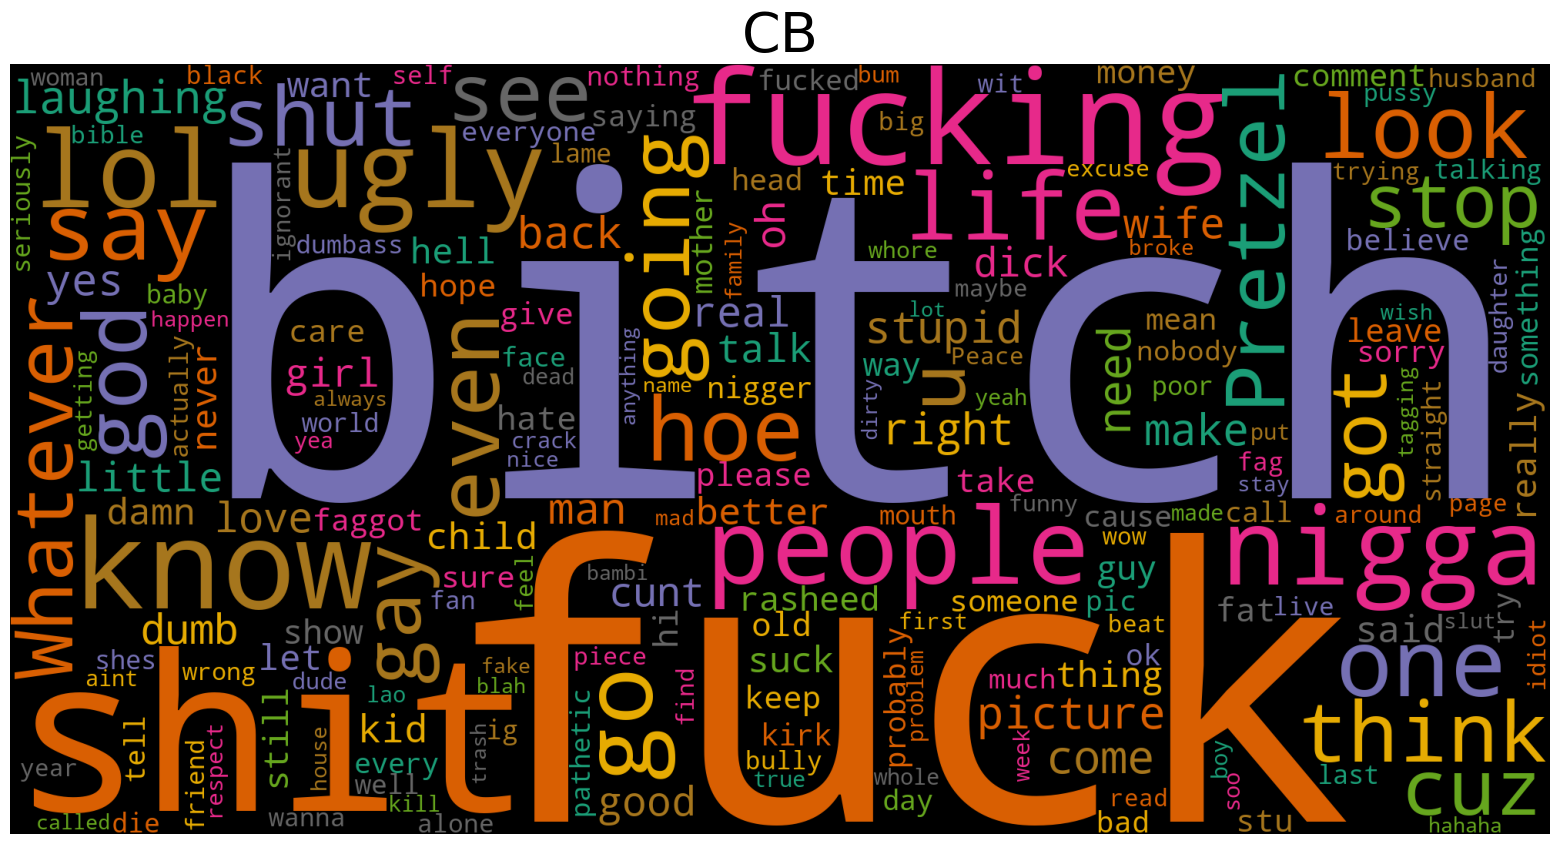

In [39]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
subset1 = text_formatting[text_formatting['Overall_CB_Status']==1]

text_cb = subset1['Comment']
cloud1=WordCloud(background_color='black',colormap="Dark2",collocations=False,width=2000,height=1000).generate(" ".join(text_cb))

plt.axis('off')
plt.title("CB",fontsize=40)
plt.imshow(cloud1)

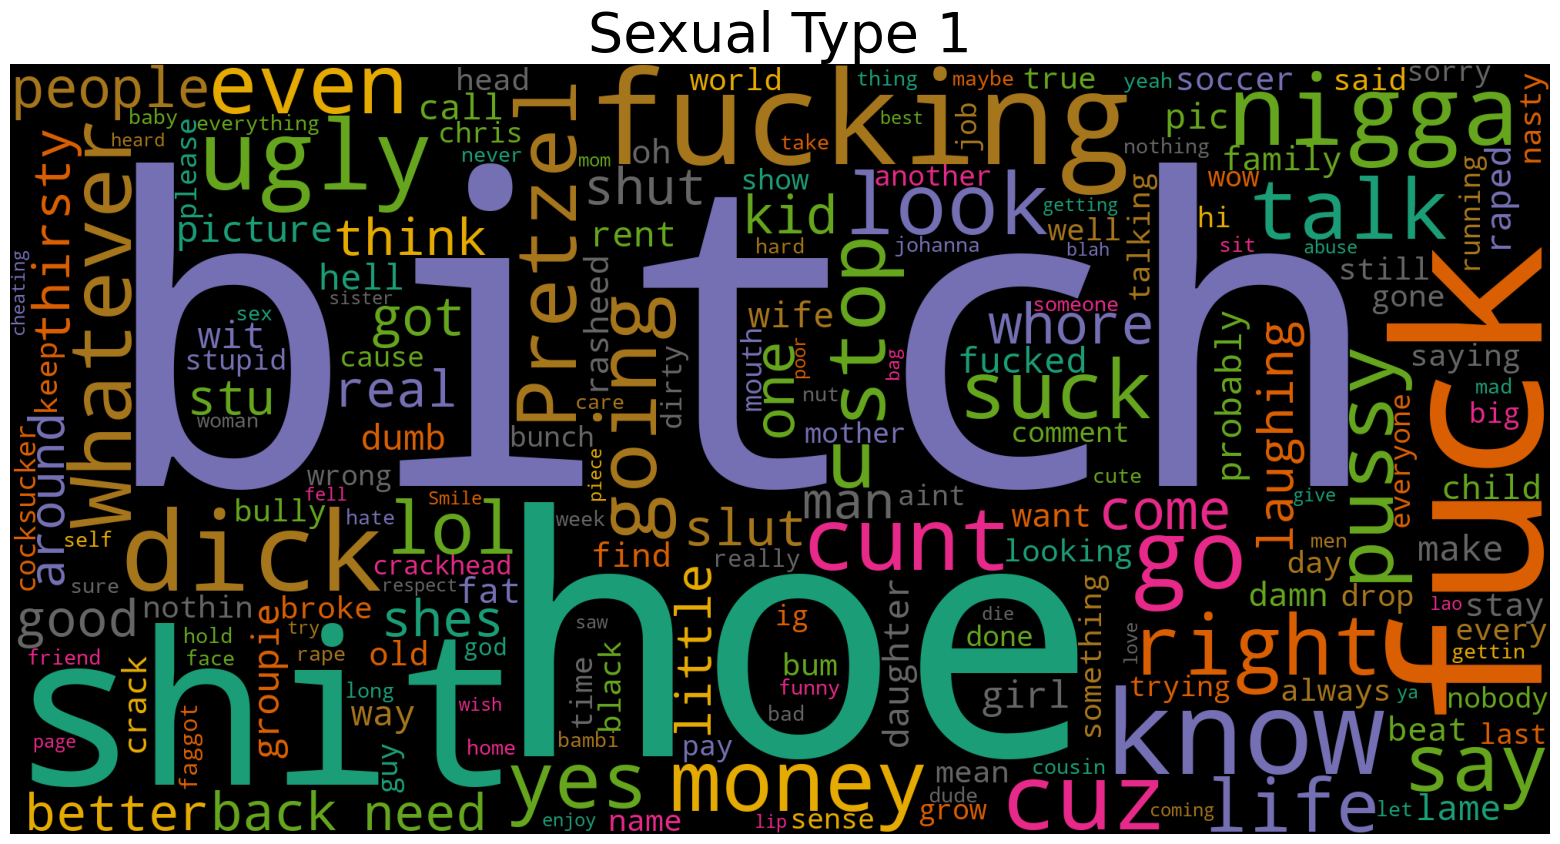

In [40]:
plt.figure(figsize=(20,10))
subset2 = text_formatting[text_formatting['Sexual_Type1']==1]

text_sexual_type1 = subset2['Comment']
cloud2=WordCloud(background_color='black',colormap="Dark2",collocations=False,width=2000,height=1000).generate(" ".join(text_sexual_type1))

plt.axis('off')
plt.title("Sexual Type 1",fontsize=40)
plt.imshow(cloud2)

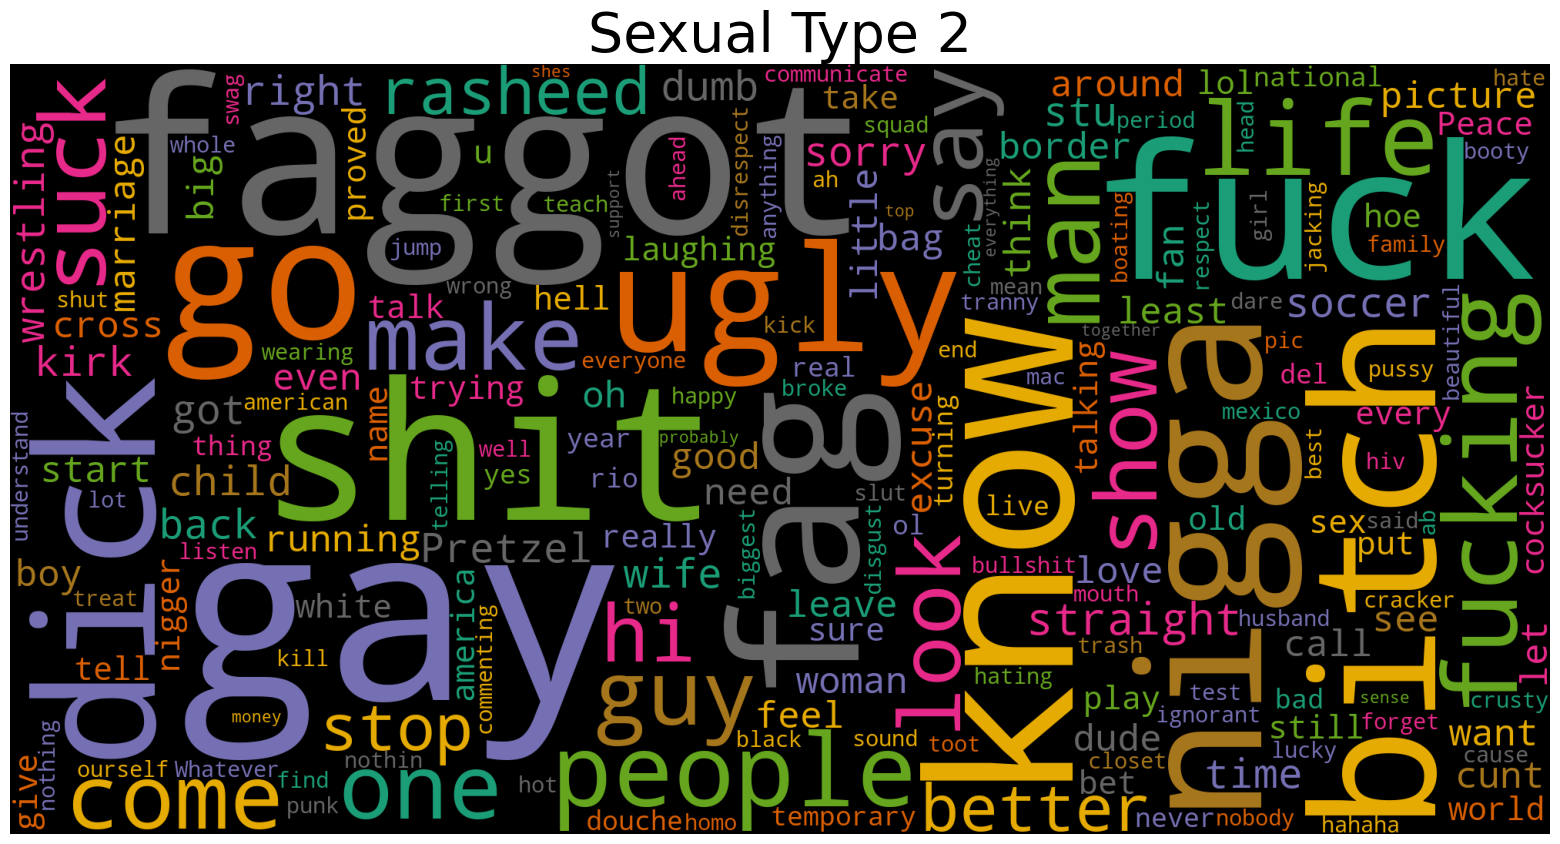

In [41]:
plt.figure(figsize=(20,10))
subset3 = text_formatting[text_formatting['Sexual_Type2']==1]

text_sexual_type2 = subset3['Comment']
cloud3=WordCloud(background_color='black',colormap="Dark2",collocations=False,width=2000,height=1000).generate(" ".join(text_sexual_type2))

plt.axis('off')
plt.title("Sexual Type 2",fontsize=40)
plt.imshow(cloud3)

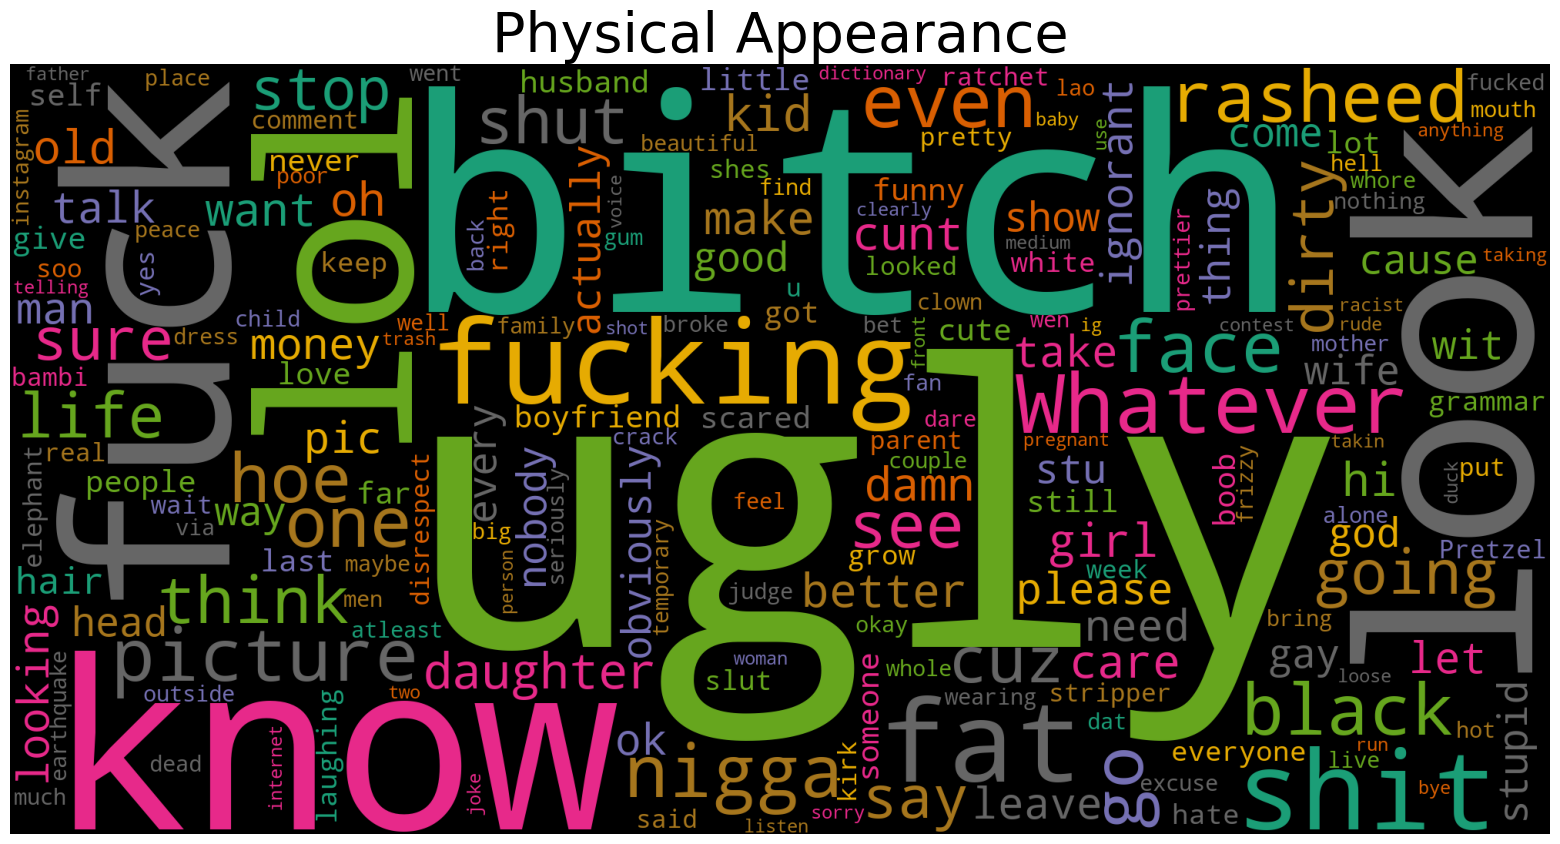

In [42]:
plt.figure(figsize=(20,10))
subset4 = text_formatting[text_formatting['Physical_Appearance']==1]

text_physcial_appearance = subset4['Comment']
cloud4=WordCloud(background_color='black',colormap="Dark2",collocations=False,width=2000,height=1000).generate(" ".join(text_physcial_appearance))

plt.axis('off')
plt.title("Physical Appearance",fontsize=40)
plt.imshow(cloud4)

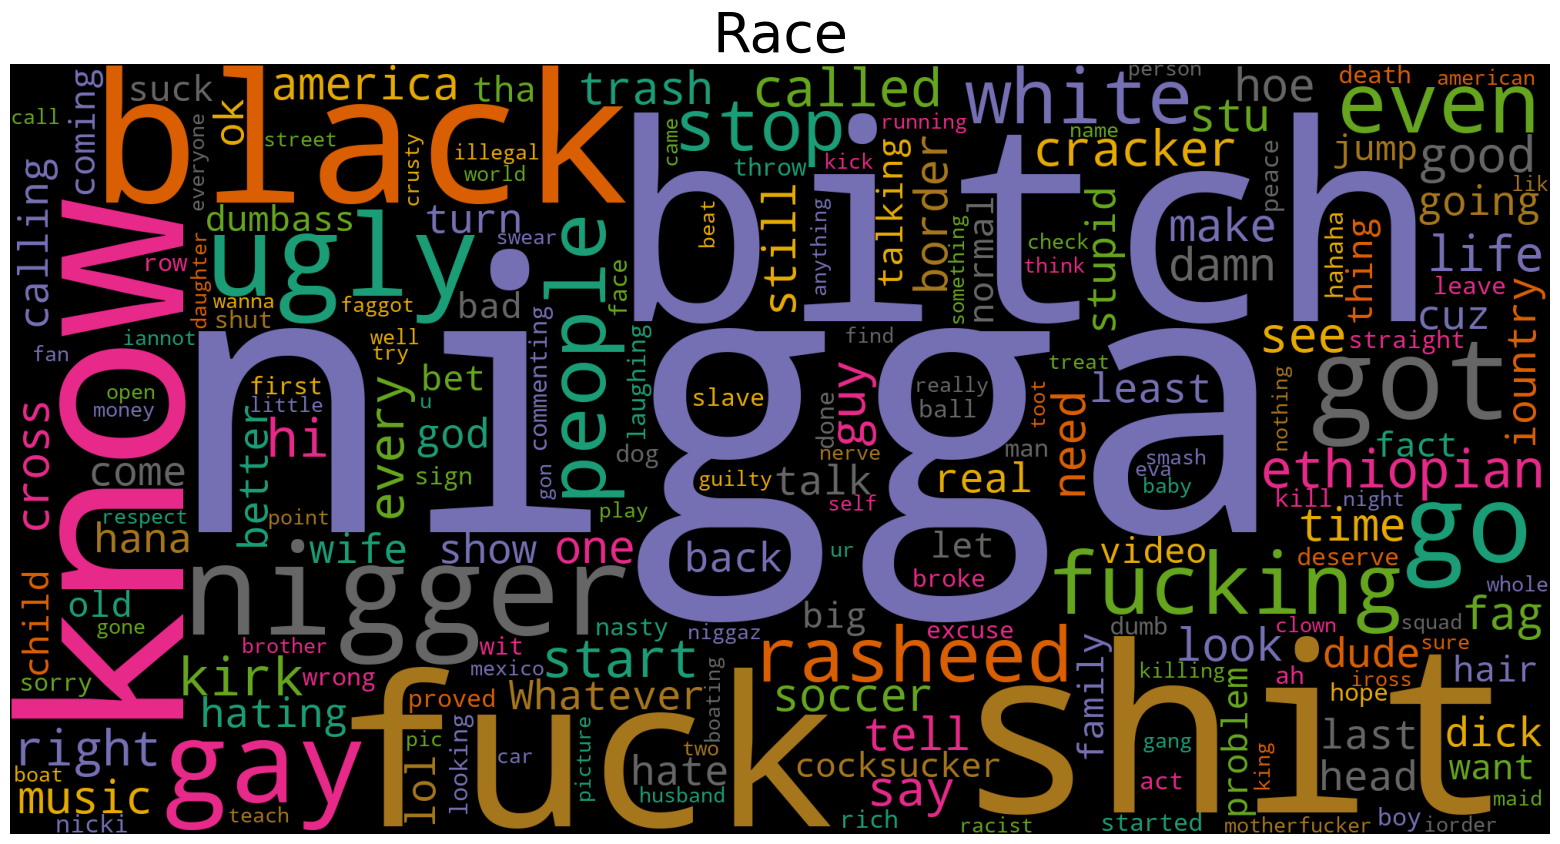

In [43]:
plt.figure(figsize=(20,10))
subset5 = text_formatting[text_formatting['Race']==1]

text_race = subset5['Comment']
cloud5=WordCloud(background_color='black',colormap="Dark2",collocations=False,width=2000,height=1000).generate(" ".join(text_race))

plt.axis('off')
plt.title("Race",fontsize=40)
plt.imshow(cloud5)

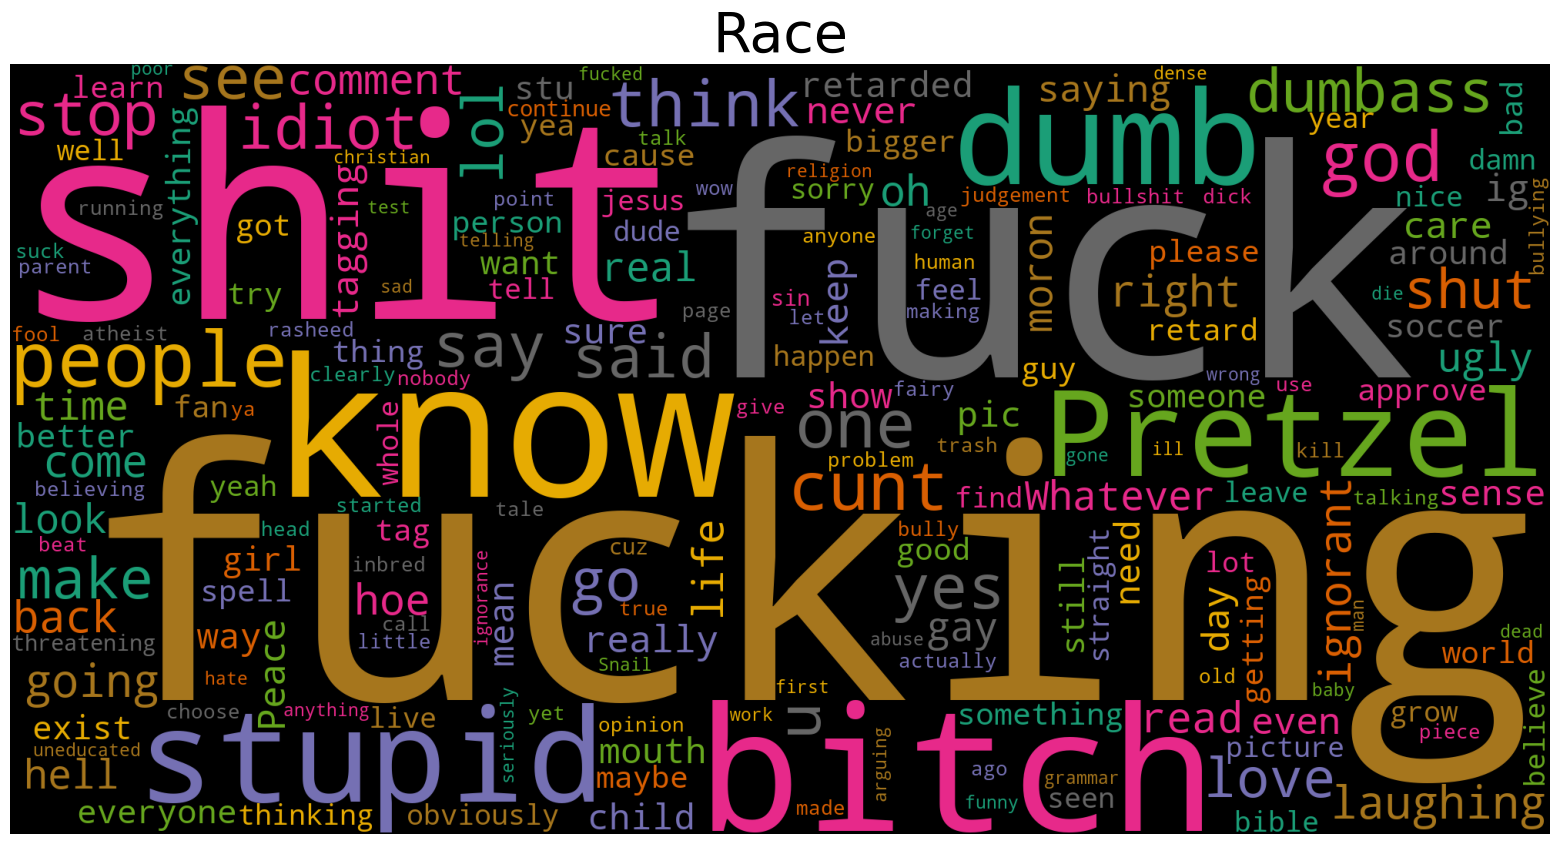

In [44]:
plt.figure(figsize=(20,10))
subset6 = text_formatting[text_formatting['Intellectual']==1]

text_int = subset6['Comment']
cloud6=WordCloud(background_color='black',colormap="Dark2",collocations=False,width=2000,height=1000).generate(" ".join(text_int))

plt.axis('off')
plt.title("Race",fontsize=40)
plt.imshow(cloud6)

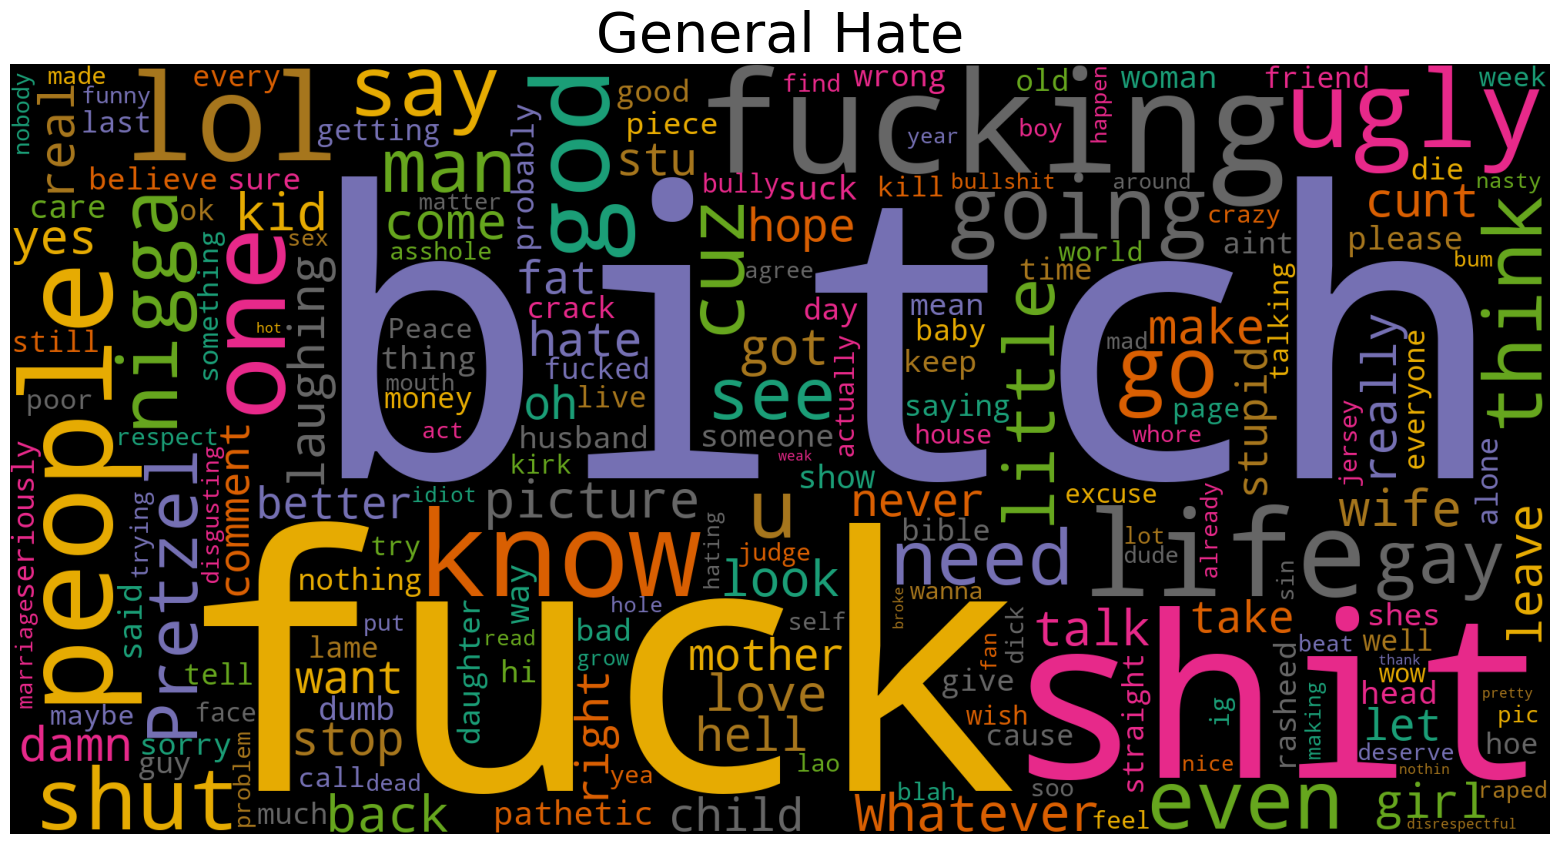

In [45]:
plt.figure(figsize=(20,10))
subset7 = text_formatting[text_formatting['General_Hate']==1]

text_general_hate = subset7['Comment']
cloud7=WordCloud(background_color='black',colormap="Dark2",collocations=False,width=2000,height=1000).generate(" ".join(text_general_hate))

plt.axis('off')
plt.title("General Hate",fontsize=40)
plt.imshow(cloud7)

In [47]:
text_formatting.to_csv('./preprocess_data_v4.csv', index=False)